In [1]:
from jaxtyping import Float, Array
from typing import Callable, NamedTuple, Union, Tuple, Any
from functools import partial
import chex
import optax
import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax, jacfwd, vmap, grad, jit
from jax.tree_util import tree_map, tree_reduce
import flax
import flax.linen as nn
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from jax.flatten_util import ravel_pytree
from dataclasses import dataclass

from itertools import cycle

import torch
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from torchvision.transforms import ToTensor

import jax_dataloader.core as jdl

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
from rebayes.base import *
from rebayes.utils.utils import *
from rebayes.utils.avalanche import *

In [4]:
from avalanche.benchmarks.classic import SplitMNIST

n_experiences = 5
dataset = SplitMNIST(n_experiences=n_experiences, seed=1, return_task_id=True,
                         class_ids_from_zero_in_each_exp=True, fixed_class_order=range(10))

ntrain_per_dist, ntrain_per_batch, ntest_per_batch = 20, 10, 500

Xtr, Ytr, Xte, Yte =  make_avalanche_data(dataset, ntrain_per_dist, ntrain_per_batch, ntest_per_batch)
Xtr_flat = flatten_batch(Xtr)



In [5]:
class RebayesSum(Rebayes):
    """The belief state is the sum of all the input X_t values."""
    def __init__(
        self,
        params: RebayesParams,
        shape_in, 
        shape_out
    ):
        self.params = params
        self.shape_in = shape_in
        self.shape_out = shape_out

    def init_bel(self) -> Belief:
        bel = Belief(dummy = jnp.zeros(self.shape_in))
        return bel
    
    def update_state(
        self,
        bel: Belief,
        X: Float[Array, "input_dim"],
        Y: Float[Array, "obs_dim"]
    ) -> Belief:
        return Belief(dummy = bel.dummy + X)

In [6]:

train_ds = jdl.Dataset(Xtr_flat, Ytr)
train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)

shape_in = Xtr_flat.shape[1]
shape_out = 1
estimator = RebayesSum(make_rebayes_params(), shape_in, shape_out)
bel, outputs = estimator.scan_dataloader(train_loader, callback=None)
Xsum = jnp.sum(Xtr_flat, axis=0)
assert(jnp.allclose(Xsum, bel.dummy, atol=1e-2))

In [7]:


train_ds = jdl.Dataset(Xtr, Ytr)
train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)


test_ds = jdl.Dataset(Xte, Yte)
test_loader = jdl.DataLoaderJax(test_ds, batch_size=ntest_per_batch, shuffle=False, drop_last=False)
test_iter = iter(test_loader)


def callback_dl(b, bel_pre, bel_post, Xtr, Ytr, **kwargs):
    jax.debug.print("callback on batch {b}", b=b)
    jax.debug.print("Xtr shape {x1}, Ytr shape {y1}", x1=Xtr.shape, y1=Ytr.shape)
    Xte, Yte = next(test_iter)
    jax.debug.print("Xte shape {x1}, Yte shape {y1}", x1=Xte.shape, y1=Yte.shape)
    return b

shape_in = Xtr.shape[1:]
shape_out = 1
estimator = RebayesSum(make_rebayes_params(), shape_in, shape_out)
bel, outputs = estimator.scan_dataloader(train_loader, callback=callback_dl)
Xsum = jnp.sum(Xtr, axis=0)
assert(jnp.allclose(Xsum, bel.dummy, atol=1e-2))


callback on batch 0
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)
callback on batch 1
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)
callback on batch 2
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)
callback on batch 3
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)
callback on batch 4
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)
callback on batch 5
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)
callback on batch 6
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)
callback on batch 7
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)
callback on batch 8
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (

In [8]:
def plot_batch(Xb, Yb, ttl=None):
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        #sample_idx = torch.randint(len(training_data), size=(1,)).item()
        sample_idx = i-1
        img = Xb[sample_idx]
        label = Yb[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
    if ttl is not None: plt.suptitle(ttl)
    plt.show()

callback on batch 0
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


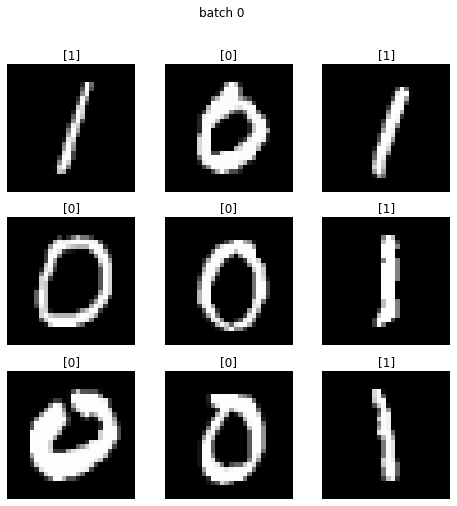

callback on batch 1
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


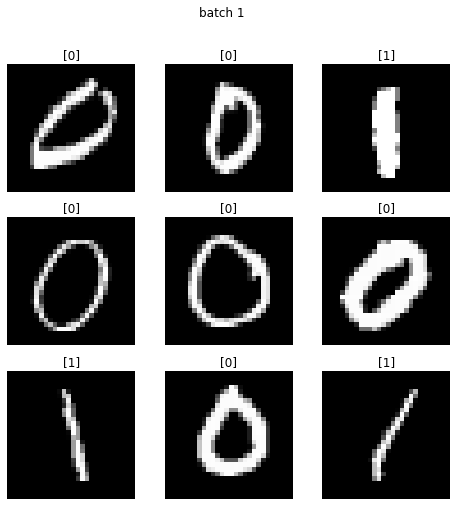

callback on batch 2
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


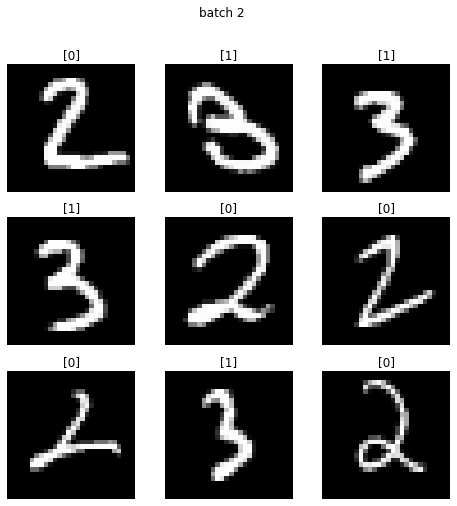

callback on batch 3
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


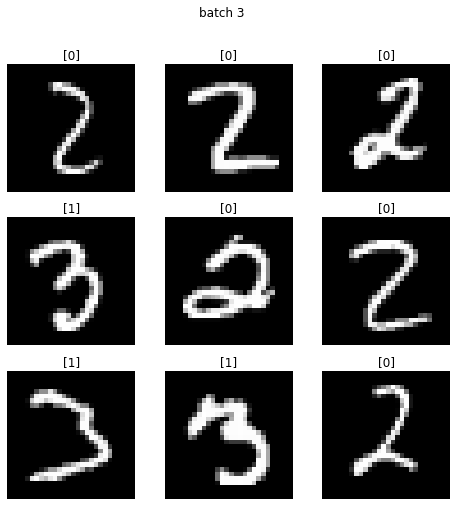

callback on batch 4
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


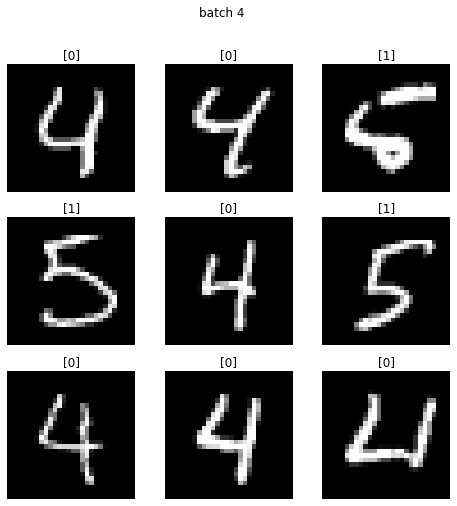

callback on batch 5
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


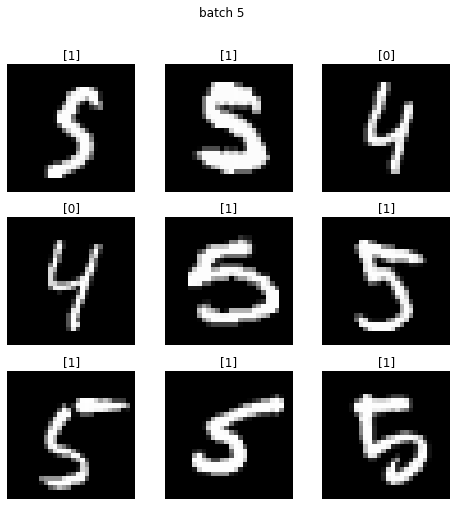

callback on batch 6
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


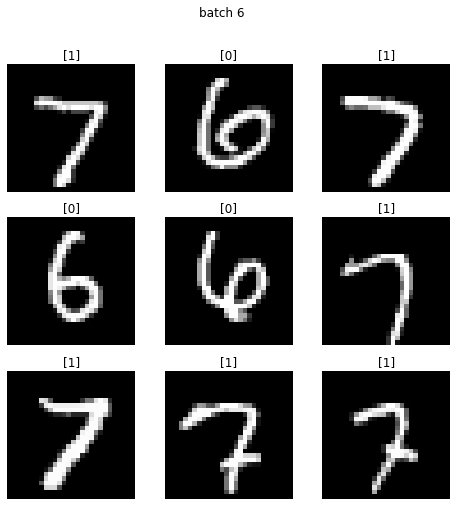

callback on batch 7
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


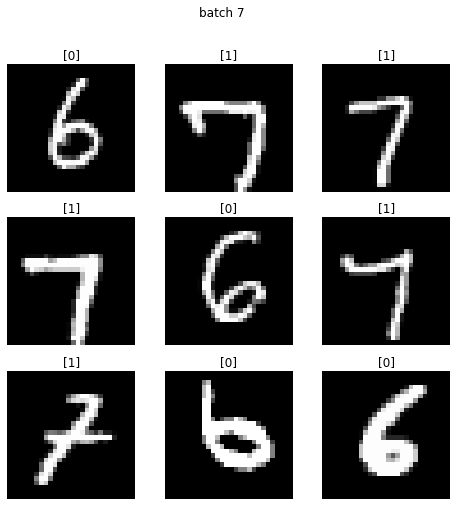

callback on batch 8
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


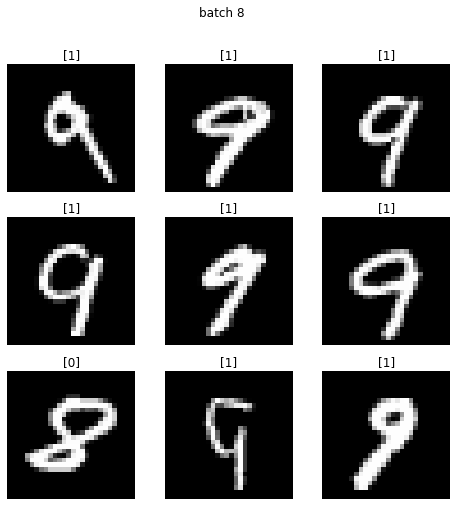

callback on batch 9
Xtr shape (10, 1, 28, 28), Ytr shape (10, 1)
Xte shape (500, 1, 28, 28), Yte shape (500, 1)


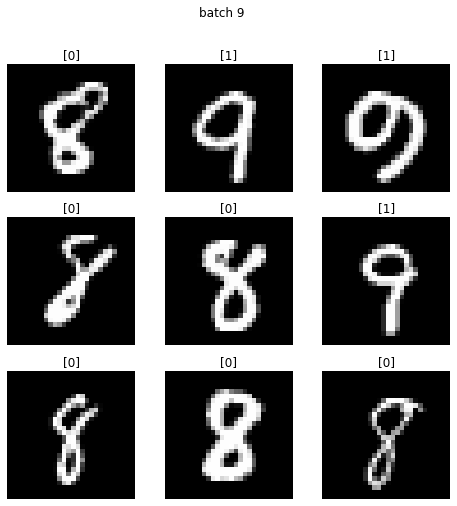

In [9]:
train_ds = jdl.Dataset(Xtr, Ytr)
train_loader = jdl.DataLoaderJax(train_ds, batch_size=ntrain_per_batch, shuffle=False, drop_last=False)

test_ds = jdl.Dataset(Xte, Yte)
test_loader = jdl.DataLoaderJax(test_ds, batch_size=ntest_per_batch, shuffle=False, drop_last=False)
test_iter = iter(test_loader)

def callback_dl(b, bel_pre, bel_post, Xtr, Ytr, **kwargs):
    jax.debug.print("callback on batch {b}", b=b)
    jax.debug.print("Xtr shape {x1}, Ytr shape {y1}", x1=Xtr.shape, y1=Ytr.shape)
    Xte, Yte = next(test_iter)
    jax.debug.print("Xte shape {x1}, Yte shape {y1}", x1=Xte.shape, y1=Yte.shape)
    plot_batch(Xte, Yte, ttl='batch {:d}'.format(b))
    return b

shape_in = Xtr.shape[1:]
shape_out = 1
estimator = RebayesSum(make_rebayes_params(), shape_in, shape_out)

bel, outputs = estimator.scan_dataloader(train_loader, callback=callback_dl)
Xsum = jnp.sum(Xtr, axis=0)
assert(jnp.allclose(Xsum, bel.dummy, atol=1e-2))